In [1]:
import pandas as pd


In [2]:
data = pd.read_csv('../data/rates.csv')
data.describe()

,daaa,dbaa,dcd1m,dcd90,dcd6m,d_ba_m6,h1rifsgfpam03nb,h0rifsgfpam06nb,h0rifsgfpay01nb,dbkac,...,t5yie,iorb,ioer,iorr,bamlh0a0hym2,bamlh0a0hym2ey,bamlc0a0cmey,bamlc0a1caaaey,bamlh0a1hybbey,bamlh0a3hycey
count,10575.000000,9816.000000,10772.000000,10963.000000,10963.000000,6119.000000,1031.000000,1030.000000,265.000000,8523.000000,...,5533.000000,1296.000000,4676.000000,4676.000000,7341.000000,7341.000000,7340.000000,7341.000000,7341.000000,7341.000000
mean,6.433627,6.966704,5.805876,5.876390,6.001234,7.375431,6.616421,6.737262,7.000528,7.146233,...,1.935259,3.571103,0.625845,0.628539,5.282178,8.452005,4.785222,4.075765,6.690811,14.138360
std,2.513913,2.056226,3.666882,3.645009,3.616321,2.959982,2.692404,2.665717,2.708325,2.854842,...,0.570149,2.096903,0.675807,0.677496,2.548015,2.806365,1.619780,1.583444,2.090813,5.348991
min,2.010000,3.110000,0.130000,0.180000,0.250000,2.970000,2.670000,2.780000,3.020000,2.980000,...,-2.240000,0.150000,0.100000,0.100000,2.410000,3.920000,1.790000,1.400000,3.010000,6.520000
25%,4.390000,5.290000,3.400000,3.630000,3.710000,5.420000,4.990000,5.070000,5.160000,5.320000,...,1.620000,1.650000,0.250000,0.250000,3.590000,6.430000,3.340000,2.670000,5.040000,10.670000
50%,5.840000,6.720000,5.540000,5.580000,5.690000,6.600000,5.740000,5.925000,6.220000,6.250000,...,1.970000,4.650000,0.250000,0.250000,4.620000,7.910000,4.730000,4.120000,6.550000,12.470000
75%,8.050000,8.290000,7.930000,7.960000,8.000000,8.750000,7.940000,8.012500,8.380000,8.450000,...,2.320000,5.400000,0.750000,0.750000,6.250000,9.490000,6.030000,5.250000,7.940000,15.290000
max,13.760000,12.040000,21.290000,20.900000,19.190000,17.400000,16.750000,15.850000,15.060000,20.000000,...,3.590000,5.400000,2.400000,2.400000,21.820000,23.260000,9.320000,8.250000,16.410000,45.020000


# Interpolate the yield curve 


In [3]:
key_rates = data.loc[:, ['date', 
                         'sofr',
                         'dgs1mo', 
                        'dgs3mo', 
                        'dgs6mo', 
                        'dgs1', 
                        'dgs2', 
                        'dgs3', 
                        'dgs5', 
                        'dgs7', 
                        'dgs10', 
                        'dgs20', 
                        'dgs30']] 
key_rates.columns = ['date', 1/365, 0.0833, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]

key_rates.dropna(inplace=True, axis=0)
key_rates.loc[:, 'date'] = pd.to_datetime(key_rates['date'], format='%Y-%m-%d')
key_rates.set_index('date', inplace=True)
key_rates /= 100  # Convert from percentage to decimal

/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [4]:
key_dfs = 1 / (1 + key_rates / 2) ** (key_rates.columns.values * 2)

In [5]:
from yield_curve_interpolation import linear_interpolation
import numpy as np

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [6]:
date_ = pd.to_datetime("2021-12-31")
i = key_rates.index.get_loc(date_)
row = key_dfs.iloc[i, :]
row2 = key_rates.iloc[i, :]
year_ = np.array(row.index.values, dtype=np.float64)
dfs_ = np.array(row.values, dtype=np.float64)
min_ = year_[0]
rate_ = np.array(key_rates.iloc[i, :].values, dtype=np.float64)
target_maturities = np.linspace(min_, 30, 1000)
interpolated_yields = linear_interpolation(dfs_, year_)
save_path = '../results/graphs/'

In [7]:

from yield_curve_interpolation import plot_yield_curve

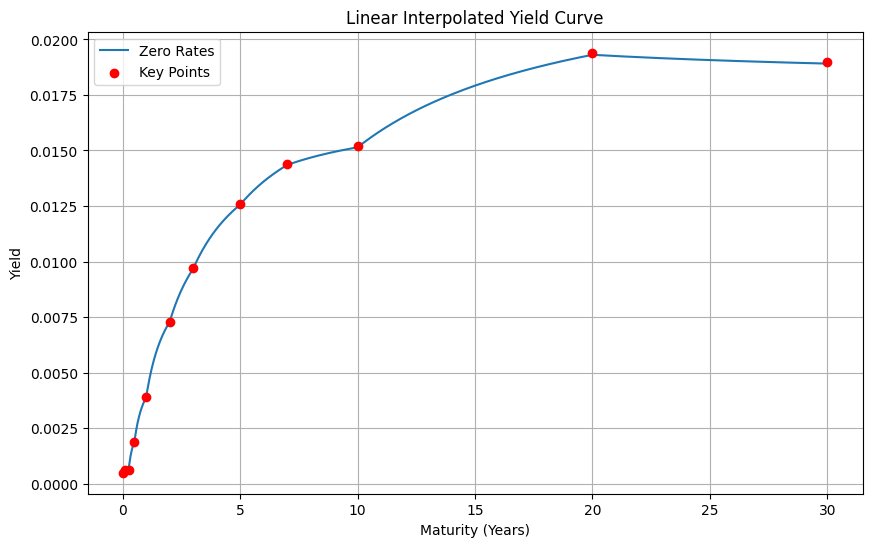

In [8]:
# Generate target maturities from 0.0833 to 30 years
yields = interpolated_yields(target_maturities)
plot_yield_curve(target_maturities, yields,
                 year_, rate_,
                title='Linear Interpolated Yield Curve',
                xlabel='Maturity (Years)',
                ylabel='Yield',
                show_dots=True,
                save_path=save_path + f'linear_interpolation_{date_.strftime("%Y%m%d")}.png')

## Cubic Spline Interpolation 

In [9]:
from yield_curve_interpolation import cubic_spline_interpolation

In [10]:
row_rate = key_rates.iloc[i, :]
year_ = np.array(row_rate.index.values, dtype=np.float64)
rate_ = np.array(row_rate.values, dtype=np.float64)
cubic_spline_yields = cubic_spline_interpolation(rate_, year_)


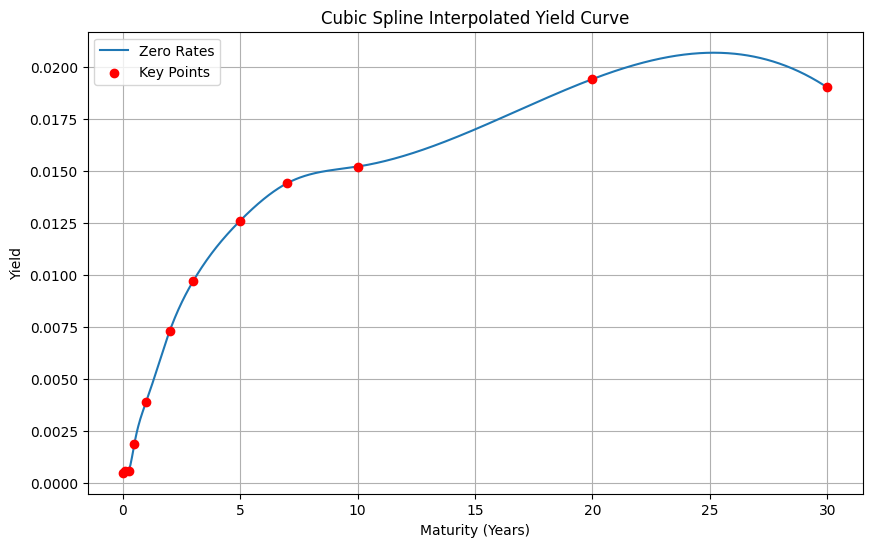

In [11]:
yields_cs = cubic_spline_yields(target_maturities)
plot_yield_curve(target_maturities, yields_cs, year_, rate_,
                    title='Cubic Spline Interpolated Yield Curve',
                    xlabel='Maturity (Years)',
                    ylabel='Yield',
                    show_dots=True,
                    save_path=save_path + f'cubic_spline_interpolation_{date_.strftime("%Y%m%d")}.png')

## Nelson-Siegel Interpolation

In [12]:
from yield_curve_interpolation import Nelson_Siegel_interpolation


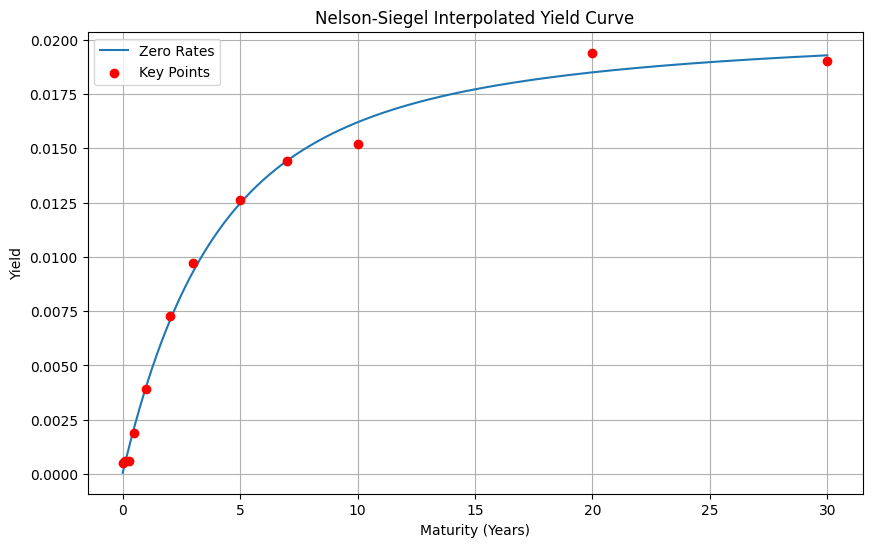

In [13]:
nelson_siegel_yields = Nelson_Siegel_interpolation(rate_, year_)
yields_ns = nelson_siegel_yields(target_maturities)
plot_yield_curve(target_maturities, yields_ns, year_, rate_,
                    title='Nelson-Siegel Interpolated Yield Curve',
                    xlabel='Maturity (Years)',
                    ylabel='Yield',
                    show_dots=True,
                    save_path=save_path + f'nelson_siegel_interpolation_{date_.strftime("%Y%m%d")}.png')

## Svensson Interpolation

In [14]:
from yield_curve_interpolation import Svensson_interpolation

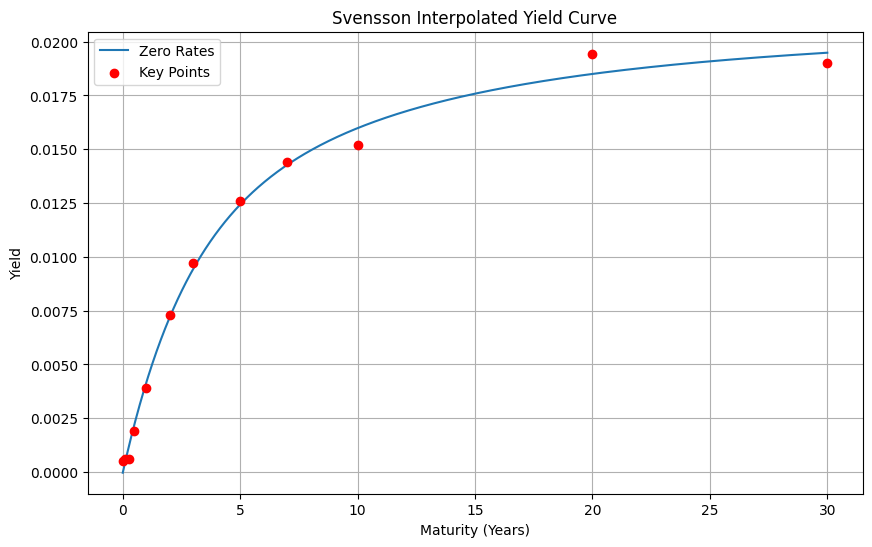

In [15]:
svensson_yields = Svensson_interpolation(rate_, year_)
yields_sv = svensson_yields(target_maturities)
plot_yield_curve(target_maturities, yields_sv, year_, rate_,
                    title='Svensson Interpolated Yield Curve',
                    xlabel='Maturity (Years)',
                    ylabel='Yield',
                    show_dots=True,
                    save_path=save_path + f'svensson_interpolation_{date_.strftime("%Y%m%d")}.png')

## monotonic convex interpolation

In [16]:
from yield_curve_interpolation import monotone_convex_interpolation

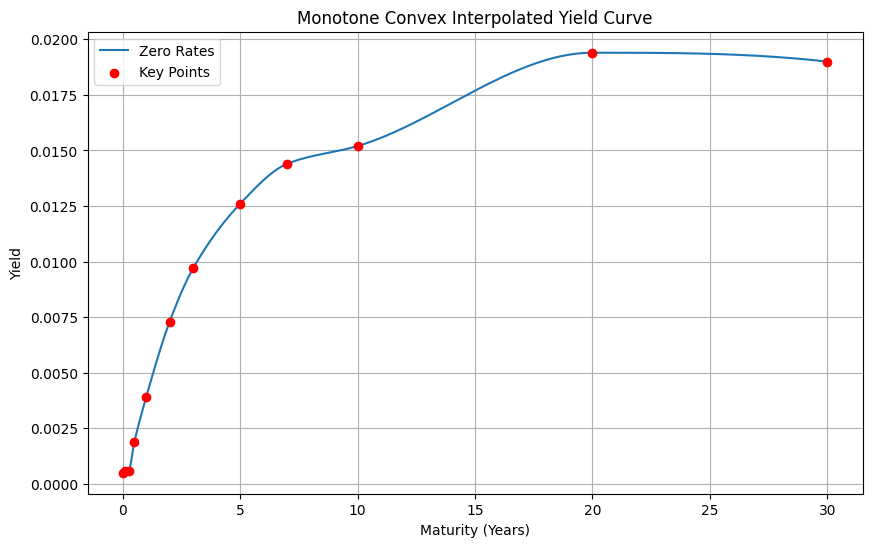

In [17]:
monotonic_convex_yields = monotone_convex_interpolation(rate_, year_)
yields_mc = monotonic_convex_yields(target_maturities)
plot_yield_curve(target_maturities, yields_mc, year_, rate_,
                    title='Monotone Convex Interpolated Yield Curve',
                    xlabel='Maturity (Years)',
                    ylabel='Yield',
                    show_dots=True,
                    save_path=save_path + f'monotone_convex_interpolation_{date_.strftime("%Y%m%d")}.png')

In [18]:
from yield_curve_interpolation import syreg_interpolation

/Users/macaulay/Library/Caches/pypoetry/virtualenvs/yield-curve-interpolation-R19XYUHD-py3.13/lib/python3.13/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/Users/macaulay/Developer/Yield_Curve_Interpolation/yield_curve_interpolation/utils.py:36: RuntimeWarning: overflow encountered in power
  discount_factors = 1 / (1 + zero_rates / compounding_freq) ** (compounding_freq * maturities)
/Users/macaulay/Developer/Yield_Curve_Interpolation/yield_curve_interpolation/utils.py:66: RuntimeWarning: divide by zero encountered in divide
  zero_rates = compounding_freq * ((1 / discount_factors) ** (1 / (compounding_freq * maturities)) - 1)


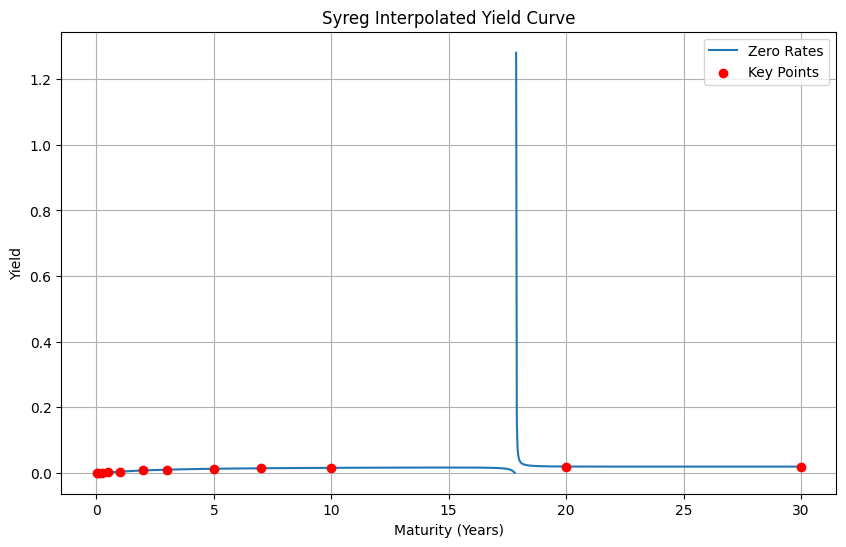

In [22]:
sr_yields = syreg_interpolation(rate_, year_, domain='yield', return_type='yield')
yields_sr = sr_yields(target_maturities)
plot_yield_curve(target_maturities, yields_sr, year_, rate_,
                    title='Syreg Interpolated Yield Curve',
                    xlabel='Maturity (Years)',
                    ylabel='Yield',
                    show_dots=True,
                    save_path=save_path + f'syreg_interpolation_{date_.strftime("%Y%m%d")}.png')